In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stat
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import math

In [2]:
import textdistance
import string


BANNED = list(string.punctuation) + [
    "restaurant",
    "house",
    "kitchen",
    "original",
    "the",
    "new"
] + [" "]
BANNED = [ban.casefold() for ban in BANNED]
CUT_CHARS = ["#", "("]


def clean_name(name):
    cleaned = name.casefold()
    for cut in CUT_CHARS:
        idx = cleaned.find(cut)
        if idx > 0:
            cleaned = cleaned[:idx]
    for ban in BANNED:
        cleaned = cleaned.replace(ban, "")
    return cleaned


def name_distance(a, b):
    sim = textdistance.jaro_winkler.similarity(a, b)
    dist = 1 - sim
    return dist

In [3]:
name_dict = pickle.load(open("models/aka_name_dbscan_name_map.pkl", "rb"))
type(name_dict), len(name_dict)

(dict, 10450)

In [4]:
cluster_dict = pickle.load(open("models/aka_name_dbscan_cluster_map.pkl", "rb"))
type(cluster_dict), len(cluster_dict)

(dict, 911)

In [5]:
RAW_NAMES, clusters = pickle.load(open("models/aka_name_dbscan_clusters.pkl", "rb"))
type(RAW_NAMES), len(RAW_NAMES), type(clusters), len(clusters),

(numpy.ndarray, 10450, numpy.ndarray, 10450)

In [6]:
df_canvass = pd.read_csv("data/canvass_records.csv.gz")
print("Read {} canvass records.".format(len(df_canvass)))
df_complaint = pd.read_csv("data/complaint_records.csv.gz")
print("Read {} complaint records.".format(len(df_complaint)))
df_all = pd.concat([df_canvass, df_complaint])
df_all["aka_name"] = df_all["aka_name"].fillna("NULL_NAME")
df_all.head()

Read 50462 canvass records.
Read 17088 complaint records.


,inspection_id,address,aka_name,city,dba_name,facility_type,inspection_date,inspection_type,latitude,license_id,...,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14
0,1981667,1725 W 47TH ST,BELLAS FUENTEZ,CHICAGO,BELLAS FUENTEZ,Restaurant,2017-01-19T00:00:00.000,Canvass,41.808460,1356217,...,0,0,0,0,0,0,0,0,0,0
1,1453500,65 W JACKSON BLVD,CARVERY,CHICAGO,CARVERY,Restaurant,2014-08-26T00:00:00.000,Canvass,41.878046,43330,...,0,0,0,0,0,0,0,0,0,0
2,1102252,11601 W TOUHY AVE,THE GREAT AMERICAN BAGEL/T3 K2,CHICAGO,THE GREAT AMERICAN BAGEL,Restaurant,2012-05-07T00:00:00.000,Canvass,42.008536,1879167,...,0,0,0,0,0,0,0,0,0,0
3,68091,2804 N CLARK ST,Wells Street Popcorn,CHICAGO,Wells Street Popcorn,Restaurant,2010-02-01T00:00:00.000,Canvass,41.932921,1954774,...,0,0,0,0,0,0,0,0,0,0
4,1482983,1847 W ROSCOE ST,FOUR MOON TAVERN,CHICAGO,FOUR MOON TAVERN,Restaurant,2015-09-14T00:00:00.000,Canvass,41.943141,51644,...,0,0,0,0,0,0,0,0,0,0


In [7]:
def count_inspections(lookup_df, names):
    res = 0
    for name in names:
        if name in lookup_df:
            res += lookup_df[name]
    return res

In [8]:
def most_common_name(lookup_df, names):
    max_count = 0
    max_name = None
    for name in names:
        count = lookup_df[name]
        if count > max_count:
            max_count = count
            max_name = name
    return max_name

In [9]:
name_count_canvass = df_canvass.groupby("aka_name")["inspection_id"].count()
name_count_complaint = df_complaint.groupby("aka_name")["inspection_id"].count()
name_count_all = df_all.groupby("aka_name")["inspection_id"].count()
cdf = pd.DataFrame(cluster_dict.items(), columns=["Cluster", "Restaurants"])
cdf["Names"] = cdf["Restaurants"].apply(lambda a: len(a))
cdf["ClusterName"] = cdf["Restaurants"].apply(lambda a: clean_name(most_common_name(name_count_all, a)))
cdf["Canvass"] = cdf["Restaurants"].apply(lambda a: count_inspections(name_count_canvass, a))
cdf["Complaint"] = cdf["Restaurants"].apply(lambda a: count_inspections(name_count_complaint, a))
cdf["CanvassRank"] = len(cdf) - stat.rankdata(cdf["Canvass"].values).astype(int) + 1
cdf["ComplaintRank"] = len(cdf) - stat.rankdata(cdf["Complaint"].values).astype(int) + 1
cdf["Inspections"] = cdf["Canvass"] + cdf["Complaint"]
cdf["OverallRank"] = len(cdf) - stat.rankdata(cdf["Inspections"].values).astype(int) + 1

In [10]:
name_to_class = {}
for rec in cdf[["Restaurants", "ClusterName"]].to_dict(orient="records"):
    for name in rec["Restaurants"]:
        name_to_class[name] = rec["ClusterName"]

In [11]:
cdf.sort_values(by="Inspections", ascending=False).head(10)

,Cluster,Restaurants,Names,ClusterName,Canvass,Complaint,CanvassRank,ComplaintRank,Inspections,OverallRank
0,0,"[#1 CHINA EXPRESS , LTD, #1 CHOP SUEY, 13 Pins...",3837,potbellysandwichworks,18552,6153,1,1,24705,1
1,-1,"[#1 WOK N ROLL, 1 2 3 EXPRESS, 1-94 RIBS & GRI...",3244,nullname,12976,3562,2,2,16538,2
804,803,"[SUBWAY, SUBWAY # 23333, SUBWAY #23983, SUBWAY...",22,subway,2107,525,3,5,2632,3
235,234,"[DUNKIN DONUTS / BASKIN ROBBINS, DUNKIN DONUT...",33,dunkindonuts,977,574,4,4,1551,4
568,567,"[MC DONALD' S # 6888, MC DONALD' S # 22100, M...",54,mcdonalds,437,1012,5,3,1449,5
360,359,"[GT's Fast Food, JIM CHING RESTAURANT, JIM'S O...",43,jimmyjohns,431,125,6,10,556,6
166,165,"[CHIPOTLE, CHIPOTLE MEXICAN GRILL, CHIPOTLE ME...",4,chipotlemexicangrill,215,145,7,8,360,7
376,375,"[HAROLD'S CHICKEN, HAROLD'S CHICKEN SHACK, H...",24,haroldschickenshack,78,217,30,6,295,8
417,416,"[INDIE BURGER, THE WING STOP EXPERTS, WINDY CI...",34,wingstop,187,34,8,25,221,9
885,884,"[WENDY'S, WENDY'S #000860, WENDY'S #001110, WE...",8,wendys,84,130,23,9,214,10


In [12]:
cdf.sort_values(by="ComplaintRank", ascending=True).head(17)

,Cluster,Restaurants,Names,ClusterName,Canvass,Complaint,CanvassRank,ComplaintRank,Inspections,OverallRank
0,0,"[#1 CHINA EXPRESS , LTD, #1 CHOP SUEY, 13 Pins...",3837,potbellysandwichworks,18552,6153,1,1,24705,1
1,-1,"[#1 WOK N ROLL, 1 2 3 EXPRESS, 1-94 RIBS & GRI...",3244,nullname,12976,3562,2,2,16538,2
568,567,"[MC DONALD' S # 6888, MC DONALD' S # 22100, M...",54,mcdonalds,437,1012,5,3,1449,5
235,234,"[DUNKIN DONUTS / BASKIN ROBBINS, DUNKIN DONUT...",33,dunkindonuts,977,574,4,4,1551,4
804,803,"[SUBWAY, SUBWAY # 23333, SUBWAY #23983, SUBWAY...",22,subway,2107,525,3,5,2632,3
376,375,"[HAROLD'S CHICKEN, HAROLD'S CHICKEN SHACK, H...",24,haroldschickenshack,78,217,30,6,295,8
169,168,"[CHURCH'S CHICKEN # 1053, CHURCH'S CHICKEN # 1...",18,churchschicken,30,181,110,7,211,11
166,165,"[CHIPOTLE, CHIPOTLE MEXICAN GRILL, CHIPOTLE ME...",4,chipotlemexicangrill,215,145,7,8,360,7
885,884,"[WENDY'S, WENDY'S #000860, WENDY'S #001110, WE...",8,wendys,84,130,23,9,214,10
360,359,"[GT's Fast Food, JIM CHING RESTAURANT, JIM'S O...",43,jimmyjohns,431,125,6,10,556,6


In [13]:
cdf["Restaurants"][243]

['EDIBLE ARRANGEMENTS',
 'EDIBLE ARRANGEMENTS OF CHICAGO-HYDE PARK',
 'Edible Arrangements',
 'Edible Arrangements #761',
 'Edible Arrangements of South Chicago']

In [14]:
list(filter(lambda n: "japan" in n, cdf["ClusterName"].values))

['yummyjapaneseandchinesecuisine']

In [15]:
for r in cdf.sort_values(by="ComplaintRank", ascending=True)["Restaurants"][2:5]:
    print(r)
    print()

["MC DONALD' S  # 6888", "MC DONALD' S # 22100", "MC DONALD'S", "MC DONALD'S RESTAURANT", 'MC DONALDS', 'MC DONALDS RESTAURANT', 'MC DONALDS-MCCORMICK PLACE NORTH', 'MCDONALD', "MCDONALD' S # 5618", "MCDONALD' S RESTAURANT", "MCDONALD'S", "MCDONALD'S   (T3- L4)", "MCDONALD'S  (T1-C10)", "MCDONALD'S  (T2   E/F)", "MCDONALD'S  (T3 HK FOOD COURT)", "MCDONALD'S #11290", "MCDONALD'S #20104", "MCDONALD'S #26364", "MCDONALD'S #490", "MCDONALD'S #5813", "MCDONALD'S #6310", "MCDONALD'S (T5/ARRIVAL)", "MCDONALD'S CORPORATION", "MCDONALD'S EXPRESS", "MCDONALD'S REST. OF ILLINOIS, INC", "MCDONALD'S RESTAURANT", "MCDONALD'S RESTAURANT  (T3 H9)", "MCDONALD'S RESTAURANTS", 'MCDONALDS', 'MCDONALDS  (T3  K9)', 'MCDONALDS #12003', 'MCDONALDS #27672', 'MCDONALDS #4655', 'MCDONALDS #5471', 'MCDONALDS #7069', 'MCDONALDS #7463', 'MCDONALDS RESTAURANT', "Mc DONALD'S  (T3  L4)", 'Mc DONALDS', 'Mc DONALDS # 25509', 'Mc DONALDS # 6771', "McDONALD'S", "McDONALD'S  (T1  B11)", "McDONALD'S  (T1-B11)", "McDONALD'S 

In [16]:
from sklearn.preprocessing import MultiLabelBinarizer
from research.strings import VIOLATIONS, MONTHS

In [17]:
rest_df = pd.DataFrame(df_canvass.copy())
rest_df["aka_name"] = rest_df["aka_name"].fillna("NULL_NAME")
rest_df["critical_found"] = rest_df[VIOLATIONS].max(axis=1)
rest_df["restaurant"] = rest_df["aka_name"].apply(lambda n: name_to_class[n])

In [18]:
mlb = MultiLabelBinarizer()
rest_mat = mlb.fit_transform(rest_df["restaurant"].values.reshape(-1, 1))
rest_mat.shape

(50462, 910)

In [19]:
rest_df_sample = rest_df.query("year < 2018")
rdf_before = rest_df_sample.query("year < 2015")
rdf_after = rest_df_sample.query("year >= 2015")

In [20]:
hr_before = rdf_before.groupby("restaurant")["critical_found"].mean()

In [21]:
hr_after = rdf_after.groupby("restaurant")["critical_found"].mean()

In [22]:
rids = set(rdf_before["restaurant"].tolist()).intersection(set(rdf_after["restaurant"].tolist()))
len(rids)

790

In [23]:
data = []
for rid in rids:
    data.append({
        "restaurant": rid,
        "rate_before": hr_before[rid],
        "rate_after": hr_after[rid]
    })

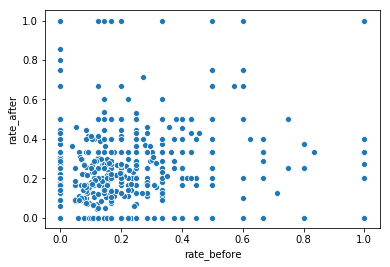

In [24]:
sns.scatterplot(x="rate_before", y="rate_after", data=pd.DataFrame(data))

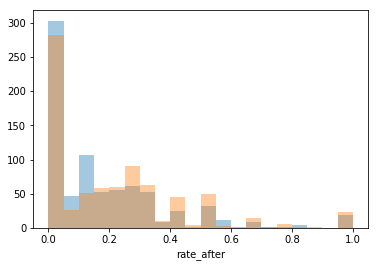

In [25]:
sns.distplot(pd.DataFrame(data)["rate_before"], kde=False, bins=np.arange(0, 1.05, 0.05))
sns.distplot(pd.DataFrame(data)["rate_after"], kde=False, bins=np.arange(0, 1.05, 0.05))
plt.show()

In [26]:
def month_counts(a):
    marr = np.zeros(len(MONTHS))
    for m in a:
        marr[m - 1] += 1
    return marr.astype(int)

In [27]:
after_samp = rdf_after.query("restaurant != 'potbellysandwichworks' and restaurant != 'nullname'")
m_after = after_samp.groupby("restaurant")["month"].apply(month_counts)
m_after.head()

restaurant
11dining        [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
25degrees       [0, 0, 2, 0, 0, 0, 0, 0, 3, 0, 0, 0]
4hermanostoo    [2, 3, 2, 2, 1, 1, 0, 1, 0, 0, 2, 0]
7eleven         [0, 0, 2, 0, 1, 0, 0, 2, 1, 2, 2, 1]
aberdeentap     [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]
Name: month, dtype: object

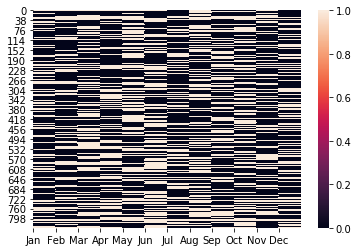

In [28]:
sns.heatmap(np.array([list(a) for a in m_after.values]) > 0)
plt.xticks(range(len(MONTHS)), MONTHS)
# plt.yticks(range(len(m_after)), m_after.index)
plt.show()

In [47]:
top_k = 20
top = cdf.query(
    "ClusterName not in ('potbellysandwichworks', 'nullname')"
).sort_values(by="CanvassRank", ascending=True).head(top_k)
print("Top {0} restaurants comprise {1}/{2} inspections ({3:.1f}%).".format(
    top_k,
    top["Inspections"].sum(),
    cdf["Inspections"].sum(),
    100 * (top["Inspections"].sum() / cdf["Inspections"].sum())
))
top.head()

Top 20 restaurants comprise 8754/67284 inspections (13.0%).


,Cluster,Restaurants,Names,ClusterName,Canvass,Complaint,CanvassRank,ComplaintRank,Inspections,OverallRank
804,803,"[SUBWAY, SUBWAY # 23333, SUBWAY #23983, SUBWAY...",22,subway,2107,525,3,5,2632,3
235,234,"[DUNKIN DONUTS / BASKIN ROBBINS, DUNKIN DONUT...",33,dunkindonuts,977,574,4,4,1551,4
568,567,"[MC DONALD' S # 6888, MC DONALD' S # 22100, M...",54,mcdonalds,437,1012,5,3,1449,5
360,359,"[GT's Fast Food, JIM CHING RESTAURANT, JIM'S O...",43,jimmyjohns,431,125,6,10,556,6
166,165,"[CHIPOTLE, CHIPOTLE MEXICAN GRILL, CHIPOTLE ME...",4,chipotlemexicangrill,215,145,7,8,360,7


In [48]:
rest_top = rest_df_sample.query("restaurant in ({})".format(
    ",".join(["'{}'".format(n) for n in top["ClusterName"].values])
))
print("Top {0} restaurants comprise {1}/{2} inspections ({3:.1f}%).".format(
    top_k,
    len(rest_top),
    len(rest_df_sample),
    100 * (len(rest_top) / len(rest_df_sample))
))
rest_top.head()

Top 20 restaurants comprise 5550/47639 inspections (11.7%).


,inspection_id,address,aka_name,city,dba_name,facility_type,inspection_date,inspection_type,latitude,license_id,...,V7,V8,V9,V10,V11,V12,V13,V14,critical_found,restaurant
2,1102252,11601 W TOUHY AVE,THE GREAT AMERICAN BAGEL/T3 K2,CHICAGO,THE GREAT AMERICAN BAGEL,Restaurant,2012-05-07T00:00:00.000,Canvass,42.008536,1879167,...,0,0,0,0,0,0,0,0,0,greatamericanbagel
57,491851,1651 W ROOSEVELT RD,Dunkin Donuts Baskin Robbins,CHICAGO,Dunkin Donuts Baskin Robbins,Restaurant,2011-02-17T00:00:00.000,Canvass,41.866749,1475713,...,0,0,0,0,0,0,0,0,0,dunkindonuts
78,1579055,9211 S COMMERCIAL AVE,McDonalds,CHICAGO,McDonalds Restaurant,Restaurant,2015-10-16T00:00:00.000,Canvass,41.727880,12886,...,0,0,0,0,0,0,0,0,0,mcdonalds
87,1115246,8548 S COMMERCIAL AVE,PALETERIA EL POTRILLO,CHICAGO,PALETERIA EL POTRILLO,Restaurant,2014-05-27T00:00:00.000,Canvass,41.739572,1356319,...,0,0,0,0,0,0,0,0,0,palmerhilton
96,1324750,1 S FRANKLIN ST,ARGO TEA,CHICAGO,ARGO TEA,Restaurant,2013-10-25T00:00:00.000,Canvass,41.881903,1974806,...,0,0,0,0,0,0,0,0,0,argotea


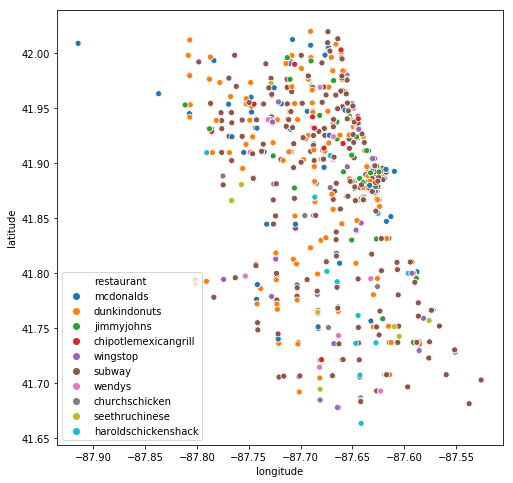

In [31]:
sns.scatterplot(x="longitude", y="latitude", hue="restaurant", data=rest_top)
plt.gcf().set_size_inches(8, 8)
plt.show()